## Importing modules

In [140]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import kstest
%matplotlib inline

# Basic model setup

In [141]:
# Parameters
p = 5
beta_true = np.array([1, 0.5, -0.5, 0.3, -0.2])
num_simulations = 1000


## Error distributions

In [146]:
# Gamma-distributed errors (centered)
shape, scale = 2.0, 1.0
mean_epsilon = shape * scale

def generate_epsilon(n):
    return gamma.rvs(a=shape, scale=scale, size=n) - mean_epsilon

## Simulation Function

In [147]:
def simulate_LPQ(n, num_simulations = 10000):
    # Design matrix (fixed across simulations)
    X = np.hstack([np.ones((n, 1)), np.random.normal(size=(n, p-1))])
    XtX_inv = np.linalg.inv(X.T @ X)

    # Storage for LPQ estimates
    beta_lpq_estimates = np.zeros((num_simulations, p))

    for i in tqdm(range(num_simulations), desc="Simulating LPQ estimates"):
        # Generate data
        epsilon = generate_epsilon(n)
        y = X @ beta_true + epsilon

        # OLS estimate and residuals
        beta_ols = XtX_inv @ X.T @ y
        z = y - X @ beta_ols

        # Moment estimates
        sigma_hat = np.sqrt(np.mean(z**2))
        m3 = np.mean((z - np.mean(z))**3) / sigma_hat**3
        m4 = np.mean((z - np.mean(z))**4) / sigma_hat**4
        gamma_vec = np.full(n, m4 - 3)
        mu_vec = np.full(n, m3)

        # Residual projection matrix
        M = np.eye(n) - X @ XtX_inv @ X.T
        M_squared = M * M  # Hadamard square

        # LPQ estimation
        beta_lpq = np.zeros(p)
        for j in range(p):
            b_j = XtX_inv[j, :] @ X.T  # shape (n,)
            A = 2 * M_squared + np.diag(gamma_vec)
            c = 3 * (b_j * mu_vec)
            h_j = -0.5 * np.linalg.solve(A, c)
            H_j = M @ np.diag(h_j) @ M

            quad_term = (1 / sigma_hat) * y.T @ H_j @ y
            trace_term = sigma_hat * np.trace(H_j)
            beta_lpq[j] = b_j @ y + quad_term - trace_term

        beta_lpq_estimates[i] = beta_lpq
    return beta_lpq_estimates

Now we will conduct the simulation for n = 100, 200, 500, 1000 points

In [156]:
def analyse(n):
    beta_pred = simulate_LPQ(n)
    for i in range(p):
        print(f"β_{i+1}: ", np.mean(beta_pred[:, i]))
    
    plt.hist(beta_pred[:,0], bins=50)
    plt.show()

    for j in range(p):
        samples = beta_pred[:, j]
        mu_hat = np.mean(samples)
        std_hat = np.std(samples, ddof=1)
        stat, p_val = kstest(samples, 'norm', args=(mu_hat, std_hat))
        print(f"β_{j+1}: KS statistic = {stat:.4f}, p = {p_val:.4f}")
        if p_val < 0.05:
            print("Reject normality (p < 0.05)")
        else:
            print("Cannot reject normality (p >= 0.05)")  


Simulating LPQ estimates: 100%|██████████| 10000/10000 [00:52<00:00, 189.56it/s]

β_1:  0.9653679782053809
β_2:  0.5004621659135953
β_3:  -0.49994562885164284
β_4:  0.2991912526124637
β_5:  -0.20265922222126495


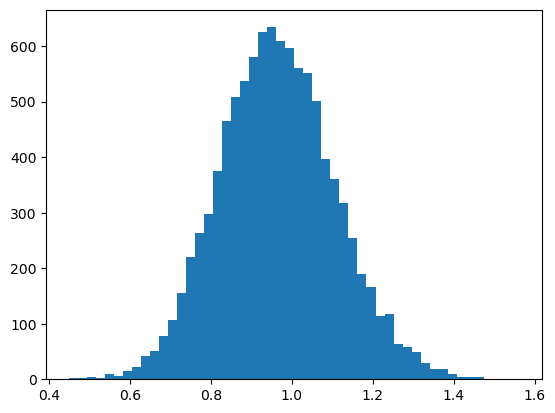

β_1: KS statistic = 0.0122, p = 0.1026
Cannot reject normality (p >= 0.05)
β_2: KS statistic = 0.0056, p = 0.9082
Cannot reject normality (p >= 0.05)
β_3: KS statistic = 0.0050, p = 0.9602
Cannot reject normality (p >= 0.05)
β_4: KS statistic = 0.0061, p = 0.8545
Cannot reject normality (p >= 0.05)
β_5: KS statistic = 0.0061, p = 0.8529
Cannot reject normality (p >= 0.05)


In [157]:
analyse(100)

Simulating LPQ estimates: 100%|██████████| 10000/10000 [02:41<00:00, 62.11it/s] 

β_1:  0.9836520335824162
β_2:  0.5002732779277032
β_3:  -0.5000657911395081
β_4:  0.3001677215307413
β_5:  -0.20134006706498614


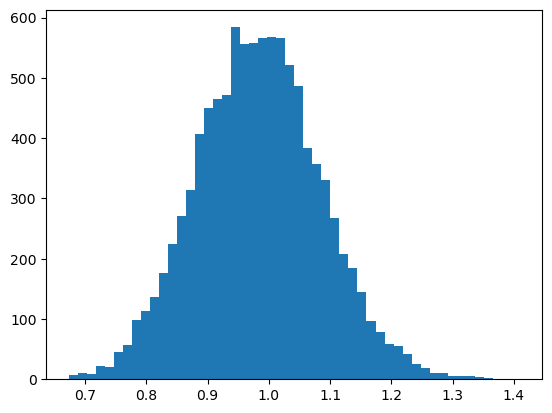

β_1: KS statistic = 0.0080, p = 0.5379
Cannot reject normality (p >= 0.05)
β_2: KS statistic = 0.0061, p = 0.8552
Cannot reject normality (p >= 0.05)
β_3: KS statistic = 0.0046, p = 0.9838
Cannot reject normality (p >= 0.05)
β_4: KS statistic = 0.0075, p = 0.6318
Cannot reject normality (p >= 0.05)
β_5: KS statistic = 0.0099, p = 0.2802
Cannot reject normality (p >= 0.05)


In [158]:
analyse(200)

Simulating LPQ estimates: 100%|██████████| 10000/10000 [13:53<00:00, 12.00it/s] 


β_1:  0.9943309450256691
β_2:  0.5014957803148217
β_3:  -0.5003163133857187
β_4:  0.299852528297462
β_5:  -0.20070938833004126


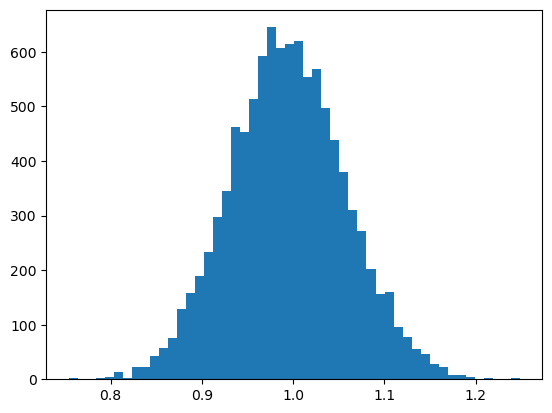

β_1: KS statistic = 0.0073, p = 0.6621
Cannot reject normality (p >= 0.05)
β_2: KS statistic = 0.0075, p = 0.6287
Cannot reject normality (p >= 0.05)
β_3: KS statistic = 0.0073, p = 0.6575
Cannot reject normality (p >= 0.05)
β_4: KS statistic = 0.0067, p = 0.7546
Cannot reject normality (p >= 0.05)
β_5: KS statistic = 0.0063, p = 0.8214
Cannot reject normality (p >= 0.05)


In [159]:
analyse(500)